# Exercise 17: Regularized regression

This homework assignment is designed to give you an intuition as an interesting property of regularization in the context of ultra-high dimensional statistical problems.

You won't need to load in any data for this homework.

---
## 1. Simulating & visualizing data (2 points)

We are going to be looking at what happens in the context where $p>n$. In order to have total control over our data, we will use simulations for this homework. First, we will need to load the `glmnet`, `tidyverse`, and `ggplot2` libraries for this assignment.


In [53]:
library(tidyverse)
library(ggplot2)
install.packages("glmnet")
library(glmnet)



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’, ‘RcppEigen’


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8



We are going to generate a data set with complex structure and try to recover it using polynomial models. For simplicity sake, use the following code to produce a response variable, $y$ that has complex structure.

*Hint: Look up what a cosine function looks like if you need a reminder.*

In [2]:
# Generate data
set.seed(121)
sigma_noise = .5
x=seq(-9,9,by=.18)
n=length(x)
y = 0.1*x + cos(x) + cos(x/20)+rnorm(n,sd=sigma_noise)

(a) Break the data into a training set (n=50) and test set (n=51) using the `sample` function to randomly select subsets of x and y.  Make a separate data frame for the training and test data.

(**Note**: *Do not* just take the first 50 observations to be the training set and last 51 observations to be the test set.)

In [4]:
set.seed(121)
train_ind = sample(1:n, size = 50, replace = FALSE)
test_ind = setdiff(1:n, train_ind)
train_df = data.frame(x = x [train_ind], y = y [train_ind])
test_df = data.frame (x = x [test_ind], y = y [test_ind])



(b) Plot the training data ($x$ \& $y$). Describe the relationship that you see in the training data.

`geom_smooth()` using formula = 'y ~ x'


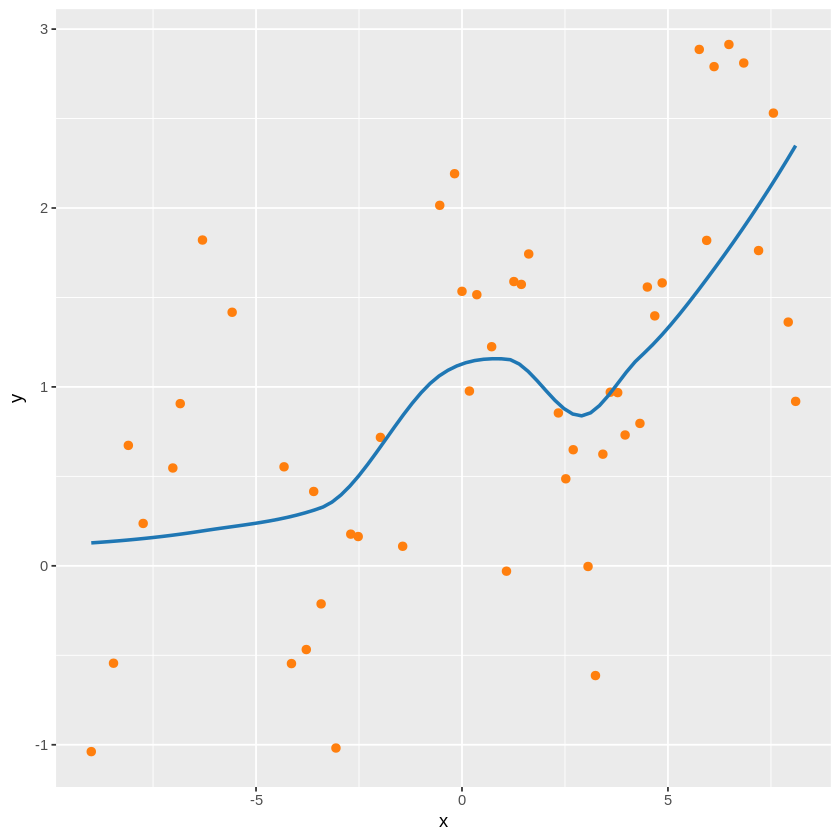

In [9]:
ggplot(train_df, aes(x = x, y = y)) +
  geom_point(color= "#FF7F0E", size = 2) +
  geom_smooth(method = "loess", color = "#1F77B4", se = FALSE, size = 1)



How would you describe the relationship between $x$ and $y$ based on this plot?

> There is a non-lineal association between x and y based on the plot. It seems like an increase positive relationship but has waves.
>

---
## 2. Bias-variance tradeoff: polynomial regression (4 points)

Recall that in polynomial regression we increase model complexity by expanding $x$ out to the power $k$ (which we call degree).


$$Y = \hat{\beta}_0 + \sum_{j=1}^K \hat{\beta}_jX^j $$  

$$ = poly(x,k)$$

(a) Fit a 2nd degree polynomial regression model to the training data. Plot the results.


*Hint: Use the* `help` *function to see how to use the* `stat_smooth()` *and* `poly()` *functions.*

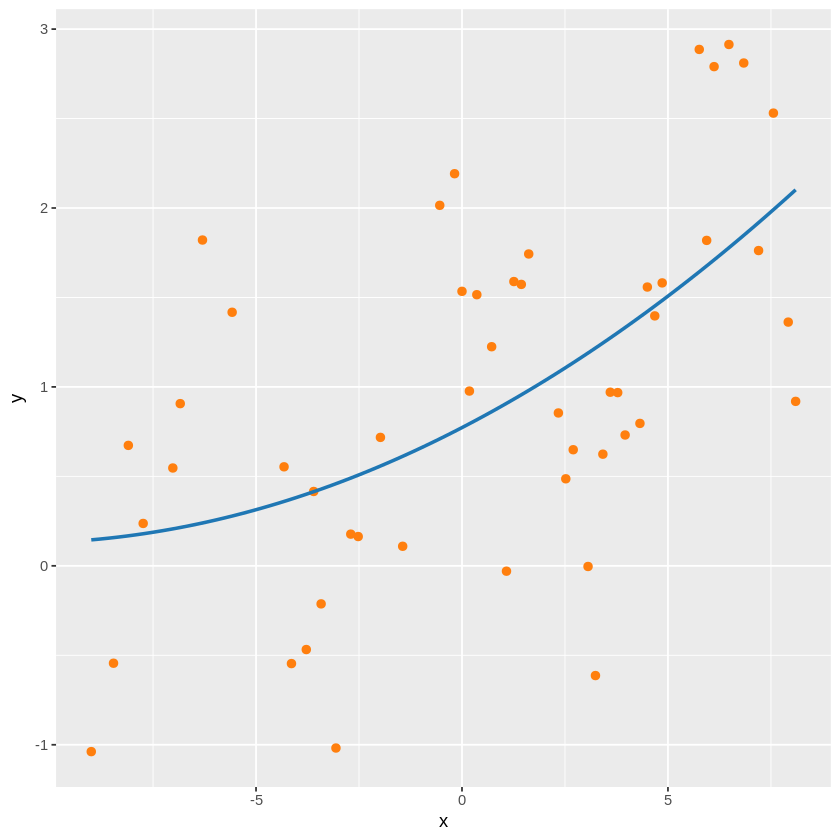

In [8]:
fit2nd = lm(y ~ poly(x,2), data = train_df)

ggplot(train_df, aes(x = x, y = y)) +
  geom_point(color= "#FF7F0E", size = 2) +
  geom_smooth(method = "lm", formula = y ~ poly(x, 2),
  color = "#1F77B4", se = FALSE, size = 1)


How well does this 2nd degree polynomial model qualitatively fit the data? Could it do better?

> It is representing the increasing tendency but is lacking of the waves from cosine terms. The model is not complex enough (underfitting).
>

(b) Fit a 12th degree polynomial to the data. Does this do qualitatively better or worse than the 2nd degree model?

,x,y
,<dbl>,<dbl>
1,0.18,0.9768865
2,-4.14,-0.5463294
3,-7.02,0.5469083
4,3.60,0.9704096
5,-8.46,-0.5442746
6,3.96,0.7313249


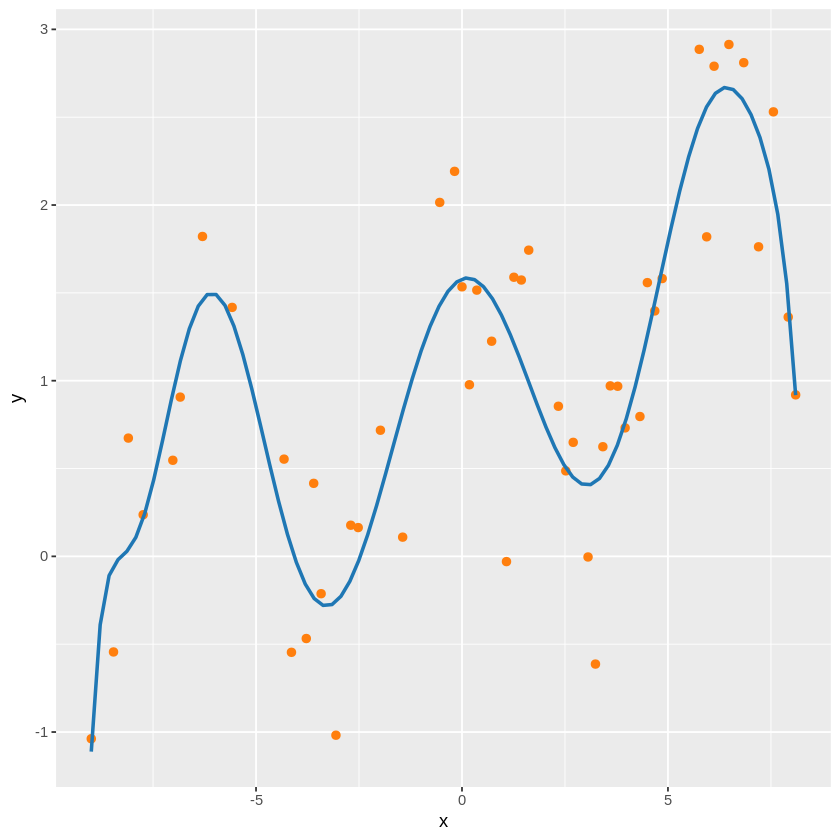

In [23]:
fit12th = lm(y ~ poly(x,12), data = train_df)

ggplot(train_df, aes(x = x, y = y)) +
  geom_point(color= "#FF7F0E", size = 2) +
  geom_smooth(method = "lm", formula = y ~ poly(x, 12),
  color = "#1F77B4", se = FALSE, size = 1)


> Yes, here we can see better the senoidal shape (waves) compared to the previous model.

(c) Modify the loop below to estimate the bias-variance tradeoff as model complexity (i.e., degree of the polynomial model, $k$) increases from 2 to 50. Use the training data to fit the model and test data to evaluate its predictive accuracy.

Visualize your results by plotting the *median* squared error for the training data and test data as a function of polynomial degree.


(**Note**: We are using median accuracies here because there are often 1 or 2 outlier values in the higher degree polynomial models that can throw off the accuracy estimates).

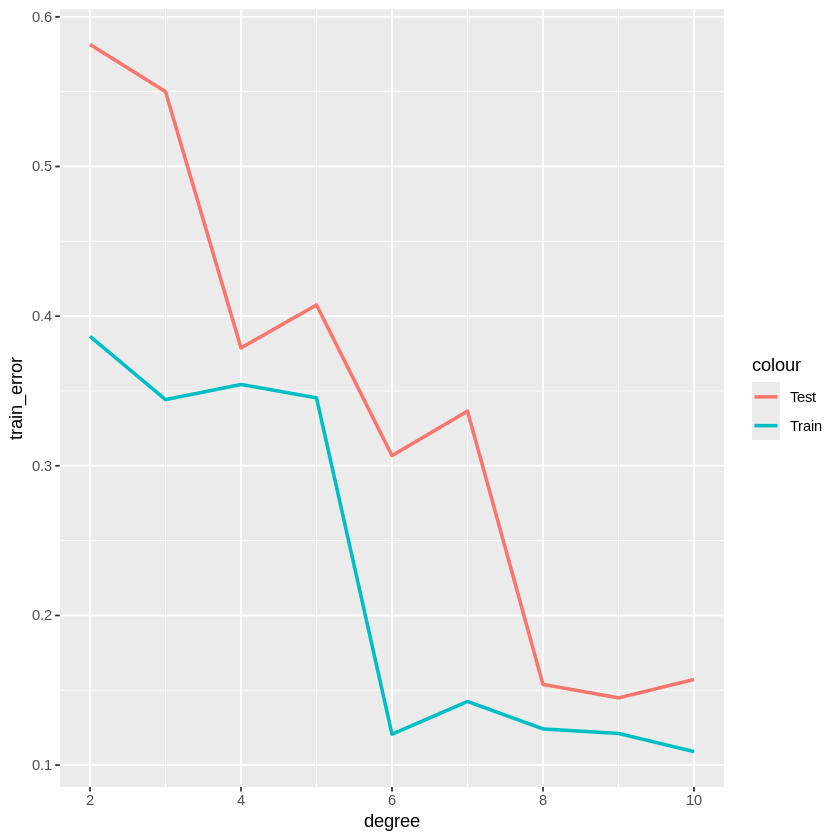

In [50]:
library(ggplot2)

max_degree <- 10
train_errors <- numeric(max_degree - 1)
test_errors <- numeric(max_degree - 1)

for (k in 2:max_degree) {
  tryCatch({
    fit = lm(y ~ poly(x, k), data = train_df)

    train_pred <- predict(fit, newdata = train_df)
    test_pred <- predict(fit, newdata = test_df)
    train_errors[k - 1] <- median((train_df$y - train_pred)^2)
    test_errors[k - 1] <- median((test_df$y - test_pred)^2)
  }, error = function(e) {
    cat("Skipping degree", k, "due to error:", e$message, "\n")
  })
}

error_df <- data.frame(
  degree = 2:max_degree,
  train_error = train_errors,
  test_error = test_errors
)

ggplot(error_df, aes(x = degree)) +
  geom_line(aes(y = train_error, color = "Train"), size = 1) +
  geom_line(aes(y = test_error, color = "Test"), size = 1)

What do you see as $k$ increase?
As k increases, the model seems to fit the training data better. However, this only happens until the treshold eight to nine.
>

(d) Now copy the code above and let's see what happens when we go beyond $p=n$ (remember, in this case $k=p$). Test polynomial models up to $k=150$. Visualize your results by plotting the *median* squared error for the training data and test data as a function of polynomial degree.

Use the `geom_vline()` function in `ggplot` to draw a vertical line where $k=n$ (here $n$ is the number of observations in the training set). This will make it clear where we cross the threshold for finding *unique* solutions in our data.



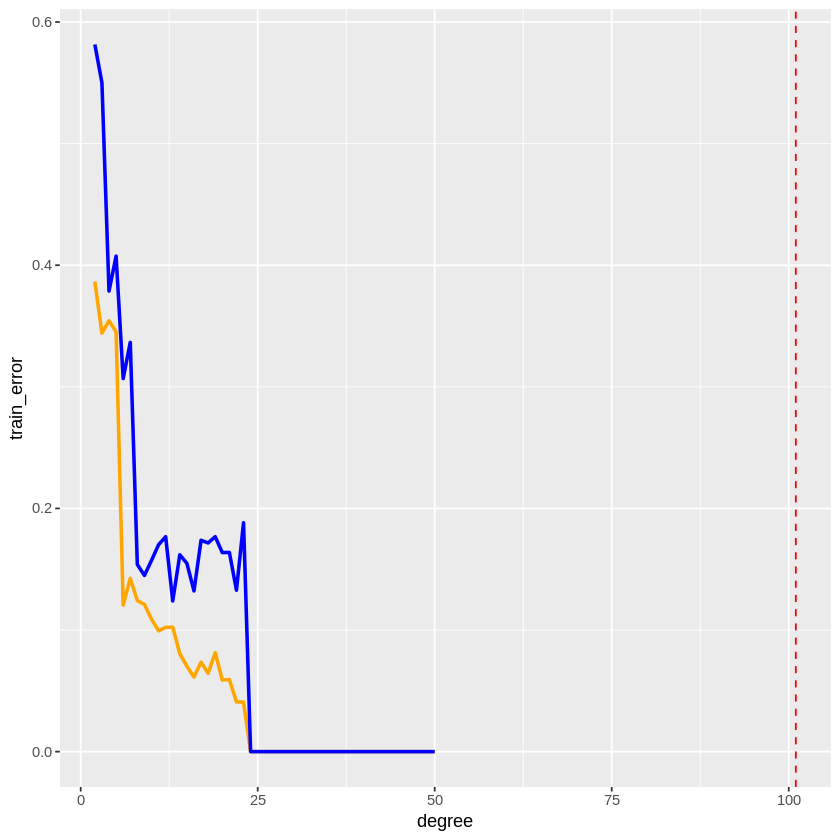

In [49]:
max_degree <- min(150, nrow(train_df))
train_errors <- numeric(max_degree - 1)
test_errors <- numeric(max_degree - 1)
n_train <- nrow(train_df)
for (k in 2:max_degree) {
  tryCatch({
    fit = lm(y ~ poly(x, k), data = train_df)
    train_pred <- predict(fit, newdata = train_df)
    test_pred <- predict(fit, newdata = test_df)
    train_errors[k - 1] <- median((train_df$y - train_pred)^2)
    test_errors[k - 1] <- median((test_df$y - test_pred)^2)
  }, error = function(e) {
    train_errors[k - 1] <- NA
    test_errors[k - 1] <- NA
  })
}

error_df <- data.frame(
  degree = 2:max_degree,
  train_error = train_errors,
  test_error = test_errors
)


ggplot(error_df, aes(x = degree)) +
  geom_line(aes(y = train_error), color = "orange", size = 1) +
  geom_line(aes(y = test_error), color = "blue", size = 1) +
  geom_vline(xintercept = n, color = "red", linetype = "dashed")


What do you see as $k$ gets larger than $n$?

> Essentially, the data reflect high variance of the test error as k gets larger than n. The model stabilized when it reaches degree 24, and reduce the error to 0 afterwards.
>

---
## 3. Applying regularization to the model fits (2 points)

Repeat the previous bias-variance tradeoff test, going up to $k=150$, but now use ridge regression with a sparsity parameter of $\lambda=0.00005$. Plot your results the same way as last time.

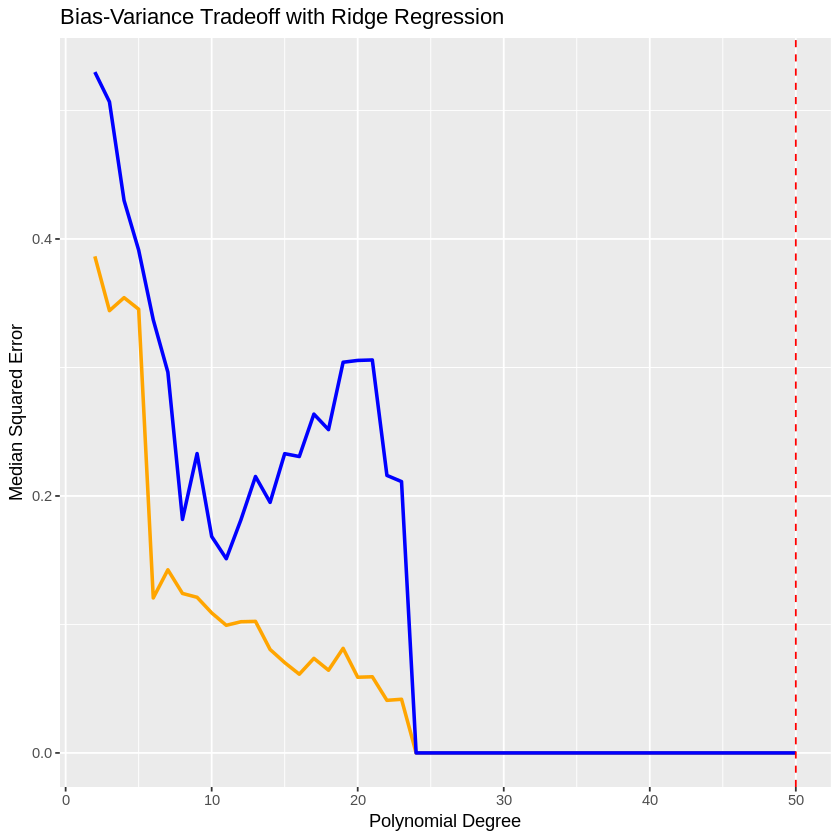

In [57]:
lambda <- 0.00005

n_train <- nrow(train_df)

max_degree <- min(150, n_train)

train_errors <- numeric(max_degree - 1)
test_errors <- numeric(max_degree - 1)

for (k in 2:max_degree) {
  tryCatch({
    fit <- glmnet(x = as.matrix(poly(train_df$x, degree = k)), y = train_df$y, alpha = 0, lambda = lambda)

    train_pred <- predict(fit, newx = as.matrix(poly(train_df$x, degree = k)), s = lambda)
    test_pred <- predict(fit, newx = as.matrix(poly(test_df$x, degree = k)), s = lambda)

    train_errors[k - 1] <- median((train_df$y - train_pred)^2)
    test_errors[k - 1] <- median((test_df$y - test_pred)^2)
  }, error = function(e) {
    # In case of an error, store NA for that degree
    train_errors[k - 1] <- NA
    test_errors[k - 1] <- NA
  })
}

error_df <- data.frame(
  degree = 2:max_degree,
  train_error = train_errors,
  test_error = test_errors
)

ggplot(error_df, aes(x = degree)) +
  geom_line(aes(y = train_error), color = "orange", size = 1) +
  geom_line(aes(y = test_error), color = "blue", size = 1) +
  geom_vline(xintercept = n_train, color = "red", linetype = "dashed") +
  labs(title = "Bias-Variance Tradeoff with Ridge Regression",
       x = "Polynomial Degree",
       y = "Median Squared Error")


What happens now when $k$ gets larger than $n$?

> We can see that when k gets larger than n, it drops to 0 and computing stops because is not ideal to generate a regression line anymore.
>

---
## 4. Reflection (2 points)

The simulations above should have shown that, when applying a regularization (i.e., a sparsity constraint), the behavior of the bias-variance tradeoff changes. Explain why this happens.

> This is the case because regularization help to deal with complex models. It improves generalization by reducing variance with the fitting tradeoff, allowing the model to enhance and reduce error.
>

---
## Bonus (1 extra credit point)
Recall that the $p=n$ threshold defines the limit for finding a *unique* solution to $Y=F(X)$ (i.e., there is only one combination of regression coefficients that is *best* at explaining variance in $Y$). With this in mind, what is regularization doing that works around this upper limit?

> *Write your response here*
>

**DUE:** 5pm EST, April 10, 2024

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here.
> I used Chat GPT to help me fix my code